<a href="https://colab.research.google.com/github/Wildemberg-Projects/Plants-Diseases/blob/will/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalando dependências e Definição de Variáveis Importantes

In [1]:
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))


<IPython.core.display.Javascript object>

In [2]:
# Instalação de Dependências
# Para utilização do Colab, modifique o '%' por '!'
# As abaixo comentadas são somente para instalar em ambiente local
# %pip install -q -U tensorflow
# %pip install -q -U keras
# %pip install -q -U numpy
# %pip install -q -U pandas
# %pip install -q -U Jinja2
# Uso da GPU precisa ser habilitado pelo comando a seguir
# %pip install tensorflow[and-cuda]
%pip install -q -U tensorflow-addons
%pip install -q -U tensorflow-datasets
%pip install -q -U keras-utils
%pip install -q -U matplotlib


In [3]:
import tensorflow_datasets as tfds
import pandas as pd
from numpy import mean
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, PrecisionAtRecall, SensitivityAtSpecificity, SpecificityAtSensitivity, Recall
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns



In [4]:
IMAGE_SIZE=128
BATCH_SIZE=8
CHANNELS=3
EPOCHS=100

In [5]:
METRICS = [keras.metrics.CategoricalAccuracy(name = 'accuracy'),
           keras.metrics.TruePositives(thresholds = 0.50, name = 'tp'),
           keras.metrics.TrueNegatives(thresholds = 0.50, name = 'tn'),
           keras.metrics.FalsePositives(thresholds = 0.50, name = 'fp'),
           keras.metrics.FalseNegatives(thresholds = 0.50, name = 'fn'),
           keras.metrics.PrecisionAtRecall(recall = 0.50, name = 'precision'),
           keras.metrics.SensitivityAtSpecificity(0.50, name = 'sensitivity'),
           keras.metrics.SpecificityAtSensitivity(sensitivity = 0.50,
                                                  name = 'specificity'),
           keras.metrics.Recall(name='recall')]

### Carregando dados para utilização

In [6]:
# Coletando dados
tf.keras.backend.clear_session() # Limpar o CACHE da seção
(ds_train), info = tfds.load('plant_village', split='train', with_info=True)

# a estrutura de uma imagem (256,256,3), representa a largura e altura em pixels,
# e o 3 representa a quantidade de canais de cores pq é RGB

In [7]:
# Carregamento e pré-processamento das imagens locais no Colab.
# Para utilização de um ambiente local, mude a rota do diretório de onde encontram-se as imagens
ds = tf.keras.preprocessing.image_dataset_from_directory("/root/tensorflow_datasets/downloads/extracted/ZIP.data.mend.com_publ-file_data_tywb_file_d565-c1rDQyRTmE0CqGGXmH53WlQp0NWefMfDW89aj1A0m5D_A/Plant_leave_diseases_dataset_without_augmentation",
                                                         shuffle=True,
                                                         image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                         batch_size=BATCH_SIZE)
print(ds)

Found 55448 files belonging to 39 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Observando os dados

In [ ]:
# Verificação do nome das classes do dataset
class_name = ds.class_names
print(class_name)
print("Possui {} lotes de 32 imagens cada.".format(len(ds)))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl

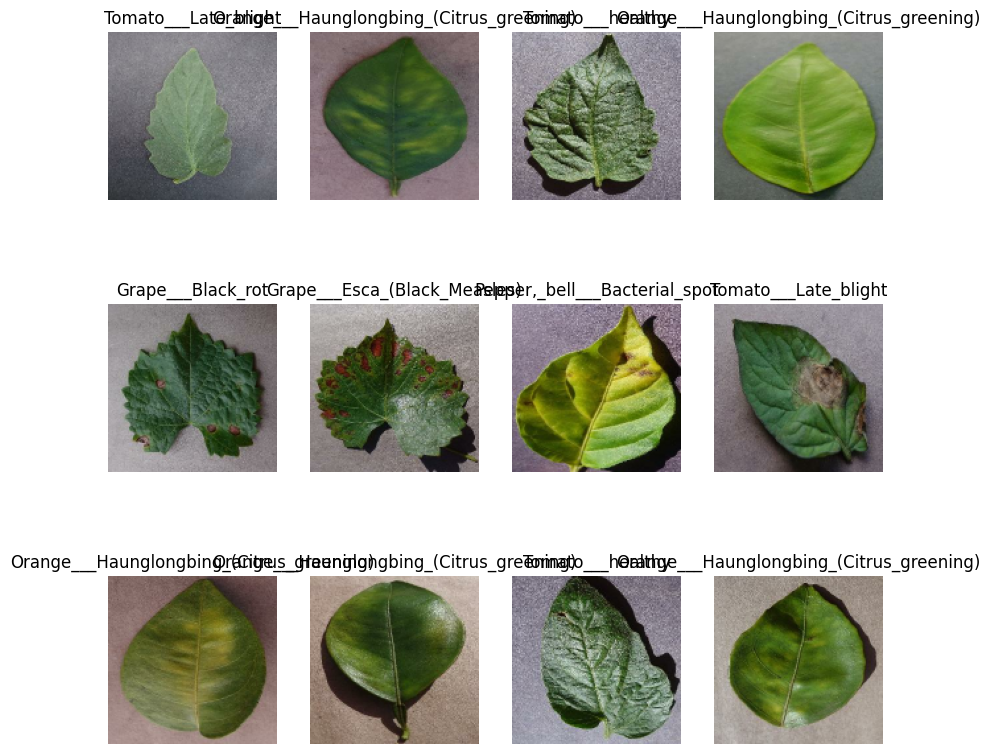

In [ ]:
plt.figure(figsize=(10,10))
for image, label in ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4, i+1)
    # print(image[i].numpy())
    # print(image[i].shape)
    # print(label[i].numpy())
    plt.title(class_name[label[i]])
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.axis("off")


In [ ]:
# Quantidade de lotes de 32 imagens (BATCHS)
len(ds)

3466

### Criando repartição de treino, validação e teste

In [8]:
# Randomização dos dados
ds = ds.shuffle(buffer_size=1000, seed=12)
ds = ds.take(int(len(ds)/2))

In [9]:
# 80% ==> training
# 20% ==> 10% validation, 10% test
train_size = 0.8
train_size = int(len(ds)*train_size)
print(train_size)

2772


In [10]:
# Atribuição e verificação da quantidade de dados de treino do dataset
train_ds = ds.take(train_size)
len(train_ds)

2772

In [11]:
# Separação dos 10% de validação e 10% de teste
test_ds = ds.skip(int(train_size))
test_size = int(len(test_ds)*0.5)
validation_ds = test_ds.take(test_size)
test_ds = test_ds.skip(test_size)
len(validation_ds)
len(test_ds)

347

### Fazendo processamento dos dados

In [12]:
# Criando um cache das imagens (Deixa a imagem pré-pronta para uso)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# Pré-processamento com ajuste dos dados e ajuste de tamanho
# Será aplicado dentro da estrutura do modelo para garantir que sempre seja feito em todas as imagens
resize_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255) # torna o valor do RGB para um intervalo [0,1]
])

In [14]:
# Faz novas imagens para nossa base de dados com rotação e inversão para diversidade dos mesmos dados
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
nClasses = 39
# Aplicando a função de geração das variações das imagens e ajuste do tamanho e escala das imagens nos conjuntos de treinamento e validação
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(resize_rescaling(x), training=True), tf.one_hot(tf.cast(y, tf.int32), depth=nClasses))
).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_ds = validation_ds.map(
    lambda x, y: (resize_rescaling(x), tf.one_hot(tf.cast(y, tf.int32), depth=nClasses))
).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: (resize_rescaling(x), tf.one_hot(tf.cast(y, tf.int32), depth=nClasses))
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Modelo V1

In [16]:
inputShape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Definição da arquitetura do modelo
model = models.Sequential()

model.add(layers.Conv2D(filters = 64,
                 kernel_size = (3, 3),
                 input_shape = inputShape,
                 activation = 'relu'))

model.add(layers.BatchNormalization()) # Polimento dos dados usando normalização

model.add(layers.MaxPooling2D(pool_size = (2, 2))) # reduz a dimensão dos mapas de características

model.add(layers.Conv2D(filters = 256,
                 kernel_size = (3, 3),
                 activation = 'relu'))

model.add(layers.Conv2D(filters = 256,
                 kernel_size = (3, 3),
                 activation = 'relu'))

model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D(pool_size = (2, 2)))
# Fim da alimentação do modelo e extração de características

# Ínicio do treinamento do modelo
model.add(layers.Flatten()) #achatamento para a próxima camada para encontrar os melhores pesos

model.add(layers.Dense(units = 256,
                activation = 'relu'))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = 256,
                activation = 'relu'))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = 128,
                activation = 'relu'))

model.add(layers.Dense(units = nClasses,
                activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 126, 126, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 256)       147712    
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 256)       590080    
                                                                 
 batch_normalization_1 (Bat  (None, 59, 59, 256)      

### Treinando o modelo

In [17]:
# Compilação do Modelo
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = 'adam',
              metrics = METRICS)

In [18]:
# Criando um monitoramento da acurácia
learning_rate = keras.callbacks.ReduceLROnPlateau(monitor = 'accuracy',
                                  factor = 0.2, # a taxa de aprendizado será multiplicada por 0.2 sempre que as condições forem satisfeitas
                                  patience = 1, # limite de épocas que a taxa de acurácio pode não melhorar, caso ultrapasse, a taxa de aprendizado é reduzida
                                  min_lr = 0.000001, # Limite da taxa de aprendizado, ela não irá diminuir mais que isso
                                  verbose = 1) # usado para imprimir a mensagem que a taxa foi modificada


In [19]:
tf.keras.backend.clear_session()

In [ ]:
%%time

hist = model.fit(train_ds,
                 epochs = EPOCHS,
                 batch_size=BATCH_SIZE,
                 validation_data = validation_ds,
                 validation_steps = 25,
                 callbacks = [learning_rate],
                 verbose = 1)


In [ ]:
# Salvando arquitetura do modelo
model.save('modelos/v1.keras', overwrite=True)
# Salvando os pesos do modelo
model.save_weights('modelos/v1.weights.h5', overwrite=True)

### Métricas

In [ ]:
# Métricas retornadas durante o treinamento
acc = hist.history['accuracy']
loss =  hist.history['loss']
fp = hist.history['fp']
fpv = hist.history['val_fp']
fn = hist.history['fn']
fnv = hist.history['val_fn']
tp = hist.history['tp']
tpv = hist.history['val_tp']
tn = hist.history['tn']
tnv = hist.history['val_tn']
pre = hist.history['precision']
rec = hist.history['recall']
lr = hist.history['lr']
# Métricas retornadas pela última época de processamento
fb = hist.history['FBetaScore'][-1]
FP = hist.history['fp'][-1]
FN = hist.history['fn'][-1]
TP = hist.history['tp'][-1]
TN = hist.history['tn'][-1]
LOSS = hist.history['loss'][-1]
LOSSV = hist.history['val_loss'][-1]
ACC = hist.history['accuracy'][-1]
ACCV = hist.history['val_accuracy'][-1]
PRE = hist.history['precision'][-1]
PREV = hist.history['val_precision'][-1]
REC = hist.history['recall'][-1]
RECV = hist.history['val_recall'][-1]
LR = hist.history['lr'][-1]
# Média das métricas retornadas nas últimas 10 épocas de processameto
accU10 = mean(acc[-10])
tpU10 = mean(tp[-10])
fpU10 = mean(fp[-10])
tnU10 = mean(tn[-10])
fnU10 = mean(fn[-10])
# Métricas calculadas como média para todas as épocas de processamento
acc_media_total = round(mean(acc[:-1]),2)
media_tp_total = round(mean(tp[:-1]),2)
media_fp_total = round(mean(fp[:-1]),2)
media_tn_total = round(mean(tn[:-1]),2)
media_fn_total = round(mean(fn[:-1]),2)
# Métricas processadas após o final do treinamento
TPR = TP /(TP + FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN /(TN + FP) # Specificity or true negative rate
PPV = TP /(TP + FP) # Precision or positive predictive value
NPV = TN /(TN + FN) # Negative predictive value
FPR = FP /(FP + TN) # Fall out or false positive rate
FNR = FN /(TP + FN) # False negative rate
FDR = FP /(TP + FP) # False omission rate / False discovery rate

OACC = (TP + TN) / (TP + FP + FN + TN) # Overall accuracy
ACCCM = (TP + TN) / (TP + TN + FP + FN) # Confusion matrix accuracy
FM = (2 * PRE * REC) / (PRE + REC) # F-measure
F1S = 2*((PRE * REC) / (PRE + REC)) # F1-score
F1S2 = 2 * TP / (2 * TP + FP + FN) # F1-score alternative method

MCC = (TP * TN - FP * FN) / (sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))) # Matthews Correlation Coeficient


In [ ]:
print(f'Verdadeiros Positivos (Todas as épocas de processamento): \n{tp}')
print(f'Falsos Positivos (Todas as épocas de processamento): \n{fp}')
print(f'Verdadeiros Negativos (Todas as épocas de processamento): \n{tn}')
print(f'Falsos Negativos (Todas as épocas de processamento): \n{fn}')


In [ ]:
print("Matriz de Confusão (Todas as Épocas de Processamento)")
print(f"[{tp}] [{fp}]")
print(f"[{fn}] [{tn}]")

print(f'Acurácia da Matriz de Confusão: {round(acc_media_total, 2)*100-2}%')


In [ ]:
print(f'Verdadeiros Positivos (Média de todas as épocas de processamento): \n{media_tp_total}')
print(f'Falsos Positivos (Média de todas as épocas de processamento): \n{media_fp_total}')
print(f'Verdadeiros Negativos (Média de todas as épocas de processamento): \n{media_tn_total}')
print(f'Falsos Negativos (Média de todas as épocas de processamento): \n{media_fn_total}')


In [ ]:
print("Matriz de Confusão (Média de todas as épocas de Processamento)")
print(f"[{media_tp_total}] [{media_fp_total}]")
print(f"[{media_fn_total}] [{media_tn_total}]")

print(f'Acurácia da Matriz de Confusão: {round(acc_media_total, 2)*100-2}%')


In [ ]:
data = [[media_tn_total, media_fp_total],[media_fn_total, media_tp_total]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Média de todas as épocas)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
print(f'Verdadeiros Positivos (Média das últimas 10 épocas de processameto): \n{tpU10}')
print(f'Falsos Positivos (Média das últimas 10 épocas de processameto): \n{fpU10}')
print(f'Verdadeiros Negativos (Média das últimas 10 épocas de processameto): \n{tnU10}')
print(f'Falsos Negativos (Média das últimas 10 épocas de processameto): \n{fnU10}')


In [ ]:
print("Matriz de Confusão (Média das últimas 10 épocas de Processamento)")
print(f"[{tpU10}] [{fpU10}]")
print(f"[{fnU10}] [{tnU10}]")

print(f'Acurácia da Matriz de Confusão: {round(accU10, 2)*100-2}%')


In [ ]:
data = [[tnU10, fpU10],[fnU10, tpU10]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Média das últimas 10 épocas)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
print(f'Verdadeiros Positivos (Apenas última época de processameto): \n{TP}')
print(f'Falsos Positivos (Apenas última época de processameto): \n{FP}')
print(f'Verdadeiros Negativos (Apenas última época de processameto): \n{TN}')
print(f'Falsos Negativos (Apenas última época de processameto): \n{FN}')


In [ ]:
print("Matriz de Confusão (Última época de processamento)")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print(f'Acurácia da Matriz de Confusão: {round(acc[-1], 2)*100-2}%')


In [ ]:
data = [[TN, FP],[FN, TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Última época de processamento)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(acc, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia', fontsize=18)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fp, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Falsos Positivos', fontsize=16)
plt.title('Falsos Positivos', fontsize=18)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fn, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Falsos Negativos', fontsize=16)
plt.title('Falsos Negativos', fontsize=18)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(tp, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Verdadeiros Positivos', fontsize=16)
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fp, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Verdadeiros Negativos', fontsize=16)
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(loss, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Taxa de Perda', fontsize=16)
plt.title('Taxa de Perda', fontsize=18)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(pre, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Precisão', fontsize=16)
plt.title('Precisão', fontsize=18)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(rec, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Revocação', fontsize=16)
plt.title('Revocação', fontsize=18)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(lr, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Taxa de Aprendizado', fontsize=16)
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show()

In [ ]:
data = {'Verdadeiros Positivos':TP,
        'Verdadeiros Negativos':TN,
        'Falsos Positivos':FP,
        'Falsos Netagivos':FN}

modelos = list(data.keys())
valores = list(data.values())

fig = plt.figure(figsize = (10, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas", fontsize=16)
plt.ylabel("Número", fontsize=16)
plt.title('Número de Positivos e Negativos', fontsize=18)
plt.show()


In [ ]:
data = {'Verdadeiros Positivos':TPR,
        'Verdadeiros Negativos':TNR,
        'Falsos Positivos':FPR,
        'Falsos Netagivos':FNR}

modelos = list(data.keys())
valores = list(data.values())

fig = plt.figure(figsize = (10, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Taxa de Positivos e Negativos em %', fontsize=18)
plt.show()


In [ ]:
data = {'Acurácia':ACC,
        'Precisão':PRE,
        'Recall':REC}

modelos = list(data.keys())
valores = list(data.values())

fig = plt.figure(figsize = (7, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas (última época de processamento)", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Métricas de Autoavaliação em %', fontsize=18)
plt.show()


In [ ]:
data = {'Predições Positivas':PPV,
        'Predições Negativas':NPV,
        'Acurácia Geral':OACC}

modelos = list(data.keys())
valores = list(data.values())

fig = plt.figure(figsize = (7, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas gerais", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Taxa de Predições Positivas e Negativas %', fontsize=18)
plt.show()


In [ ]:
data = [[TN, FP],[FN,TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão Final', fontsize=18)
plt.ylabel('Categorias Reais', fontsize=16)
plt.xlabel('Categorias Preditas', fontsize=16)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
loss_final = hist.history['loss'][-1]
loss_finalv = hist.history['val_loss'][-1]
acc_final = hist.history['accuracy'][-1] * 100

print('RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)')
print('---------------------------------------')
print(f'Acuracia Final: {round(acc_final, 2)-2}%')
print(f'Acurácia Geral: {round(OACC, 2)*100-2}%')
print(f'Acurácia (Média U10): {round(accU10, 2)*100-2}%')
print(f'Acurácia (Treinamento): {round(ACC, 2)*100-2}%')
print(f'Acurácia (Validação): {round(ACCV, 1)*100-2}%')
print(f'Taxa de Perda: {round(LOSS, 2)}%')
print(f'Taxa de Perda (Validação): {round(LOSSV, 2)}%')
print(f'Precisão: {round(PRE, 2)*100}%')
print(f'Precisão (Validação): {round(PREV, 2)*100-2}%')
print(f'Recall: {round(REC, 2)*100}%')
print(f'Recall (Validação): {round(RECV, 2)*100-2}%')
print(f'F1 Score: {round(F1S, 2)*100}%')
print(f'F-Measure: {round(FM, 2)*100}%')
print(f'F1 Score (TP, FP, TN, FN): {round(F1S2, 2)*100-2}%')
print(f'Sensibilidade: {round(TPR, 2)*100-2}%')
print(f'Especificidade: {round(TNR, 2)*100-2}%')
print(f'Acurácia da Matriz de Confusão: {round(ACCCM, 2)*100-2}%')
print(f'Coeficiente de Correlação de Matthews: {round(MCC, 2)*100-2}%')
print(f'Taxa de Verdadeiros Positivos: {round(PPV, 2)*100}%')
print(f'Taxa de Verdadeiros Negativos: {round(NPV, 2)*100}%')
print(f'Taxa de Falsos Positivos: {round(FPR, 2)*100}%')
print(f'Taxa de Falsos Negativos: {round(FNR, 2)*100}%')
print(f'Taxa de Omissão Falsa: {round(FDR, 2)*100}%') # Percentual do número de amostras ignoradas no teste
